In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pygsheets
import pandas as pd
import sys
import inspect
from datetime import datetime, timedelta
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
sys.path.append(parentdir + '/functions')
import load_data
from fit_and_predict import fit_and_predict_ensemble
from functions import merge_data
from viz import viz_interactive, viz_static
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
from functions import merge_data
from fit_and_predict import add_preds
from update_severity_index import df_to_plot, add_severity_index

NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
cs = ['#6E8E96', '#D3787D', '#AC3931']
df_hospital = load_data.load_hospital_level(data_dir=oj(os.path.dirname(parentdir), 'covid-19-private-data'))
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'), preprocess=False)
df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST, cached_dir=oj(parentdir, 'data')) # adds keys like "Predicted Deaths 1-day"
df = merge_data.merge_county_and_hosp(df_county, df_hospital)
df = add_severity_index(df, NUM_DAYS_LIST)
df = df.sort_values('Total Deaths Hospital', ascending=False)
# d = df_to_plot(df, NUM_DAYS_LIST)
d = df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [8]:
df.keys()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'CMS Certification Number',
       'Hospital Name', 'Street Address_x', 'City_x', 'State_x', 'ZIP',
       'System Affiliation', 'Type of Facility',
       ...
       'Severity Emerging 6-day', 'Rural Severity 6-day', 'Surge 6-day',
       'Predicted New Deaths 7-day', 'Predicted Deaths Hospital 7-day',
       'Predicted New Deaths Hospital 7-day', 'Severity 7-day',
       'Severity Emerging 7-day', 'Rural Severity 7-day', 'Surge 7-day'],
      dtype='object', length=547)

# calculating the severity index
**some important features**
1. deaths so far$^*$
1. predicted deaths in next few days$^*$
1. number ICU beds (proxy for current resources) - if we have demand info, use that instead
1. social vulnerability index (takes into account socioeconomic status, household composition, minority status & language, housing + transportation at the county level)
1. rural or urban

$^*$note: hospital death numbers are estimated by splitting the county-level numbers based on the number of employees at each hospital

**current index calculations**
- severity index: threshold the total predicted deaths = current deaths + predicted deaths
- surge index: total predicted deaths * 2 - number ICU beds
- rural index: same as severity index, but only using rural hospitals

**proposed index calculation**
- get a percentile for each of the first 4 things and then average them
- intead of using number ICU beds, use (2 * num predicted deaths - num ICU beds)

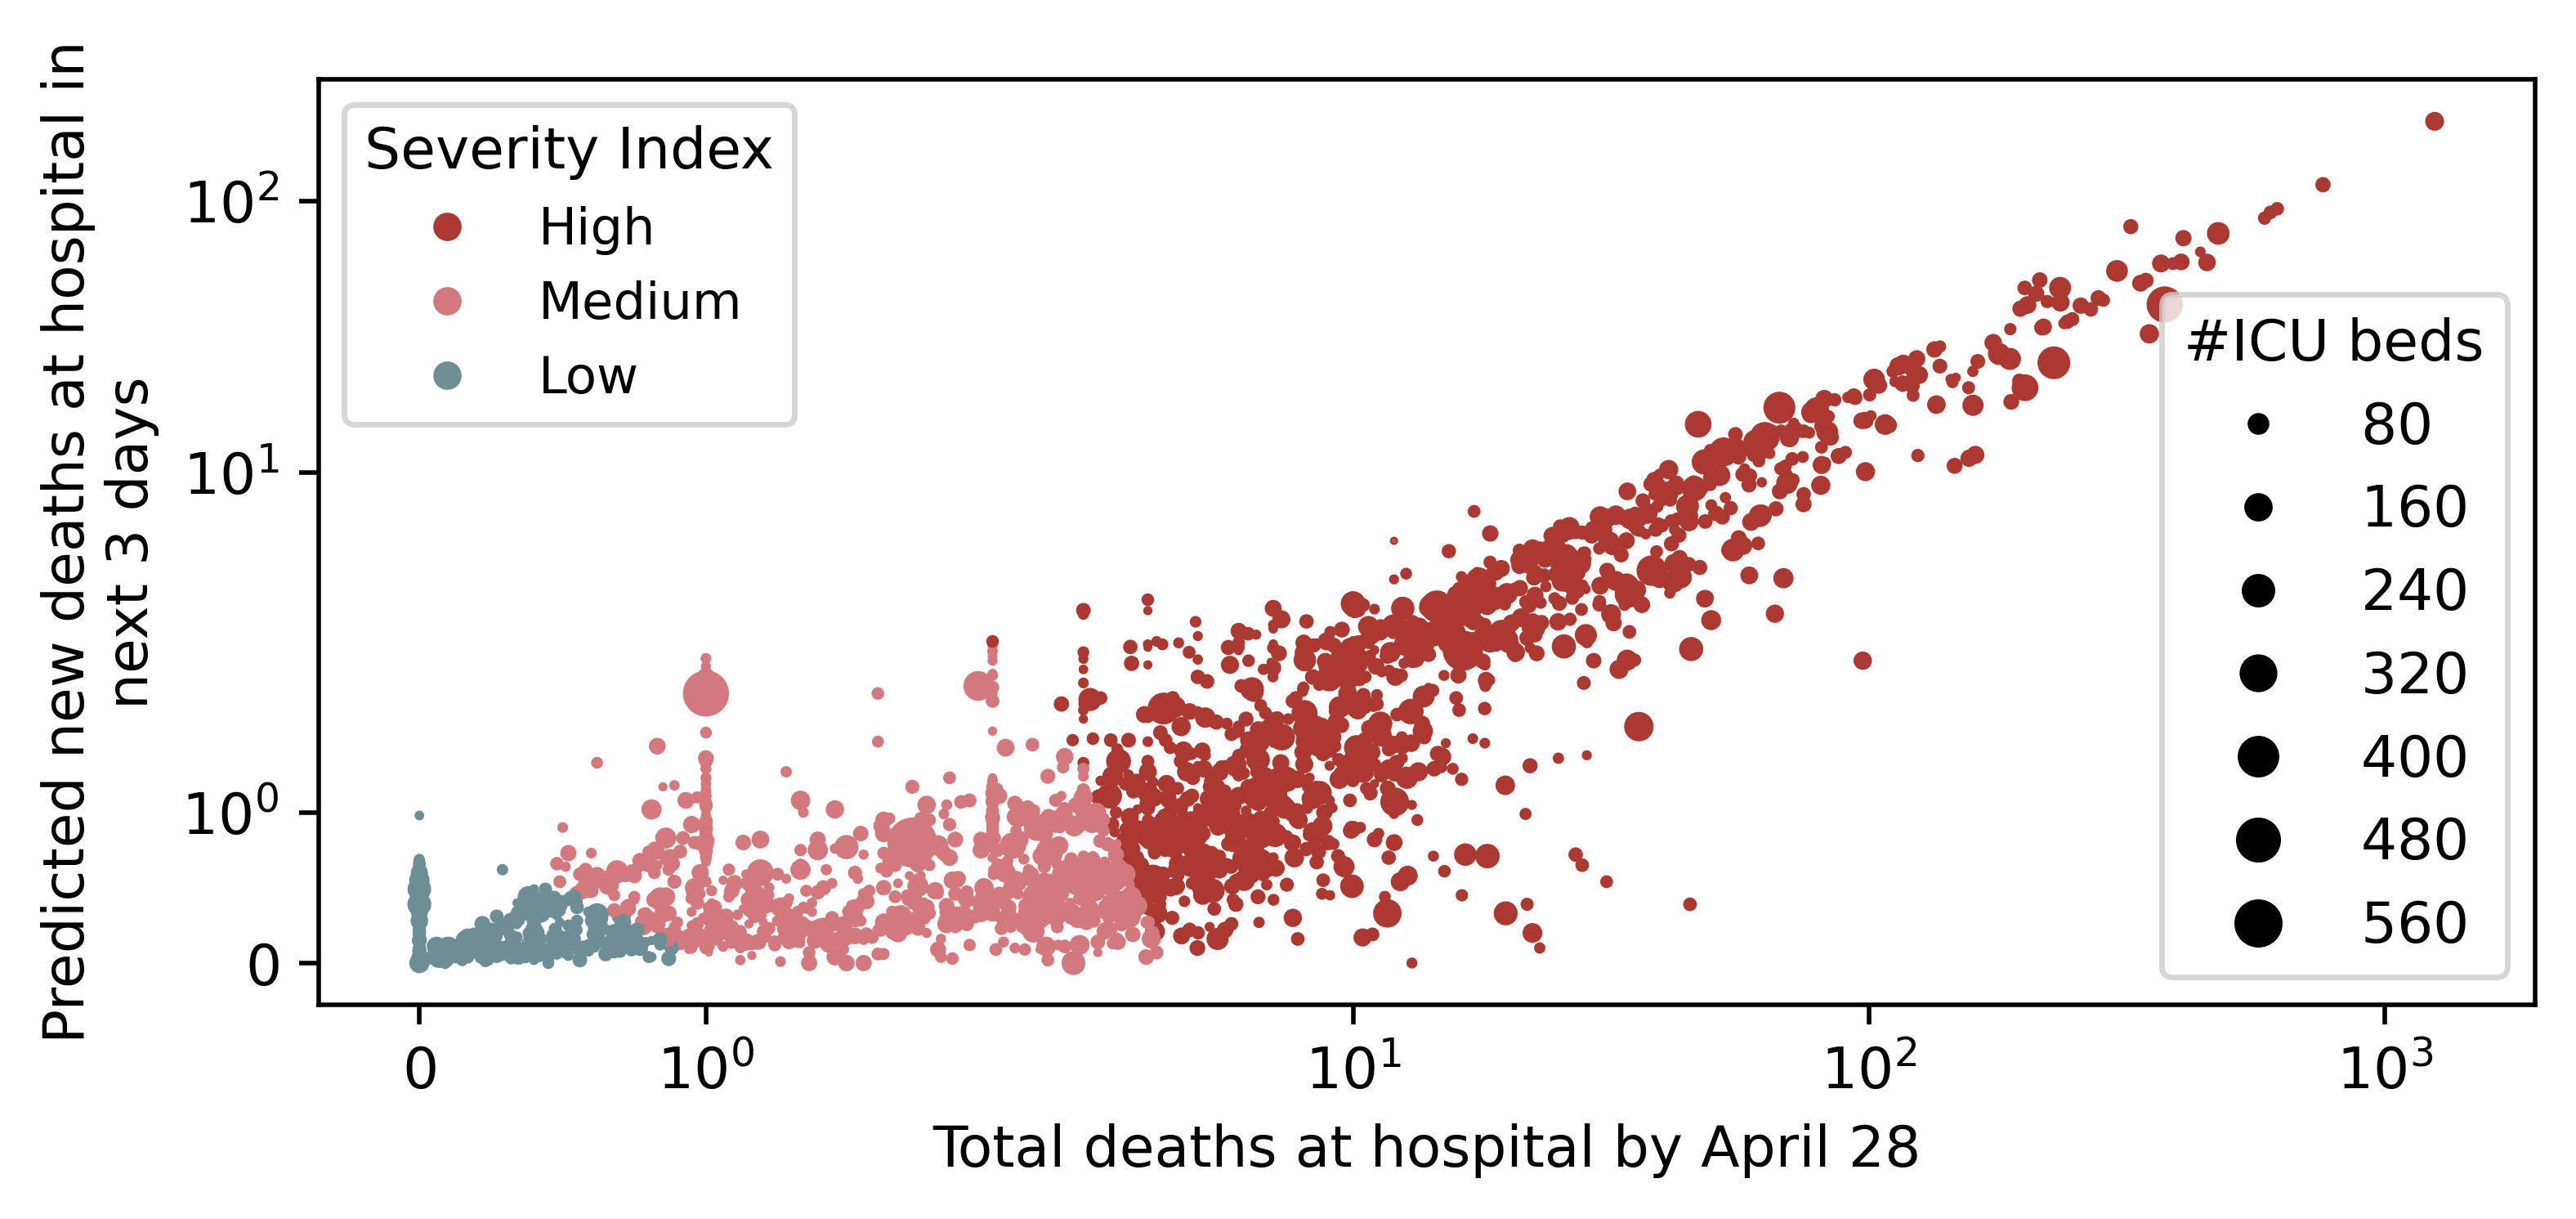

In [9]:
today = datetime.today().strftime("%B %d")
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
cs_d = {i: cs[i-1] for i in [1, 2, 3]}
# cs = ['#91bfdb','#dec34b','#fc8d59']
markersize_rescaling = 10
x = d['Total Deaths Hospital']
y = d['Predicted New Deaths Hospital 3-day']
c = [cs_d[x] for x in d['Severity 3-day']] # d['Severity 3-day'] #
s = d['ICU Beds'] / markersize_rescaling
xlab = f'Total deaths at hospital by {today}'
ylab = 'Predicted new deaths at hospital in\nnext 3 days'
colorlab = 'Severity Index'
sizelab = '#ICU beds'

viz_static.plot_scatter(x, y, c, s, xlab, ylab, colorlab, sizelab, markersize_rescaling)
plt.show()

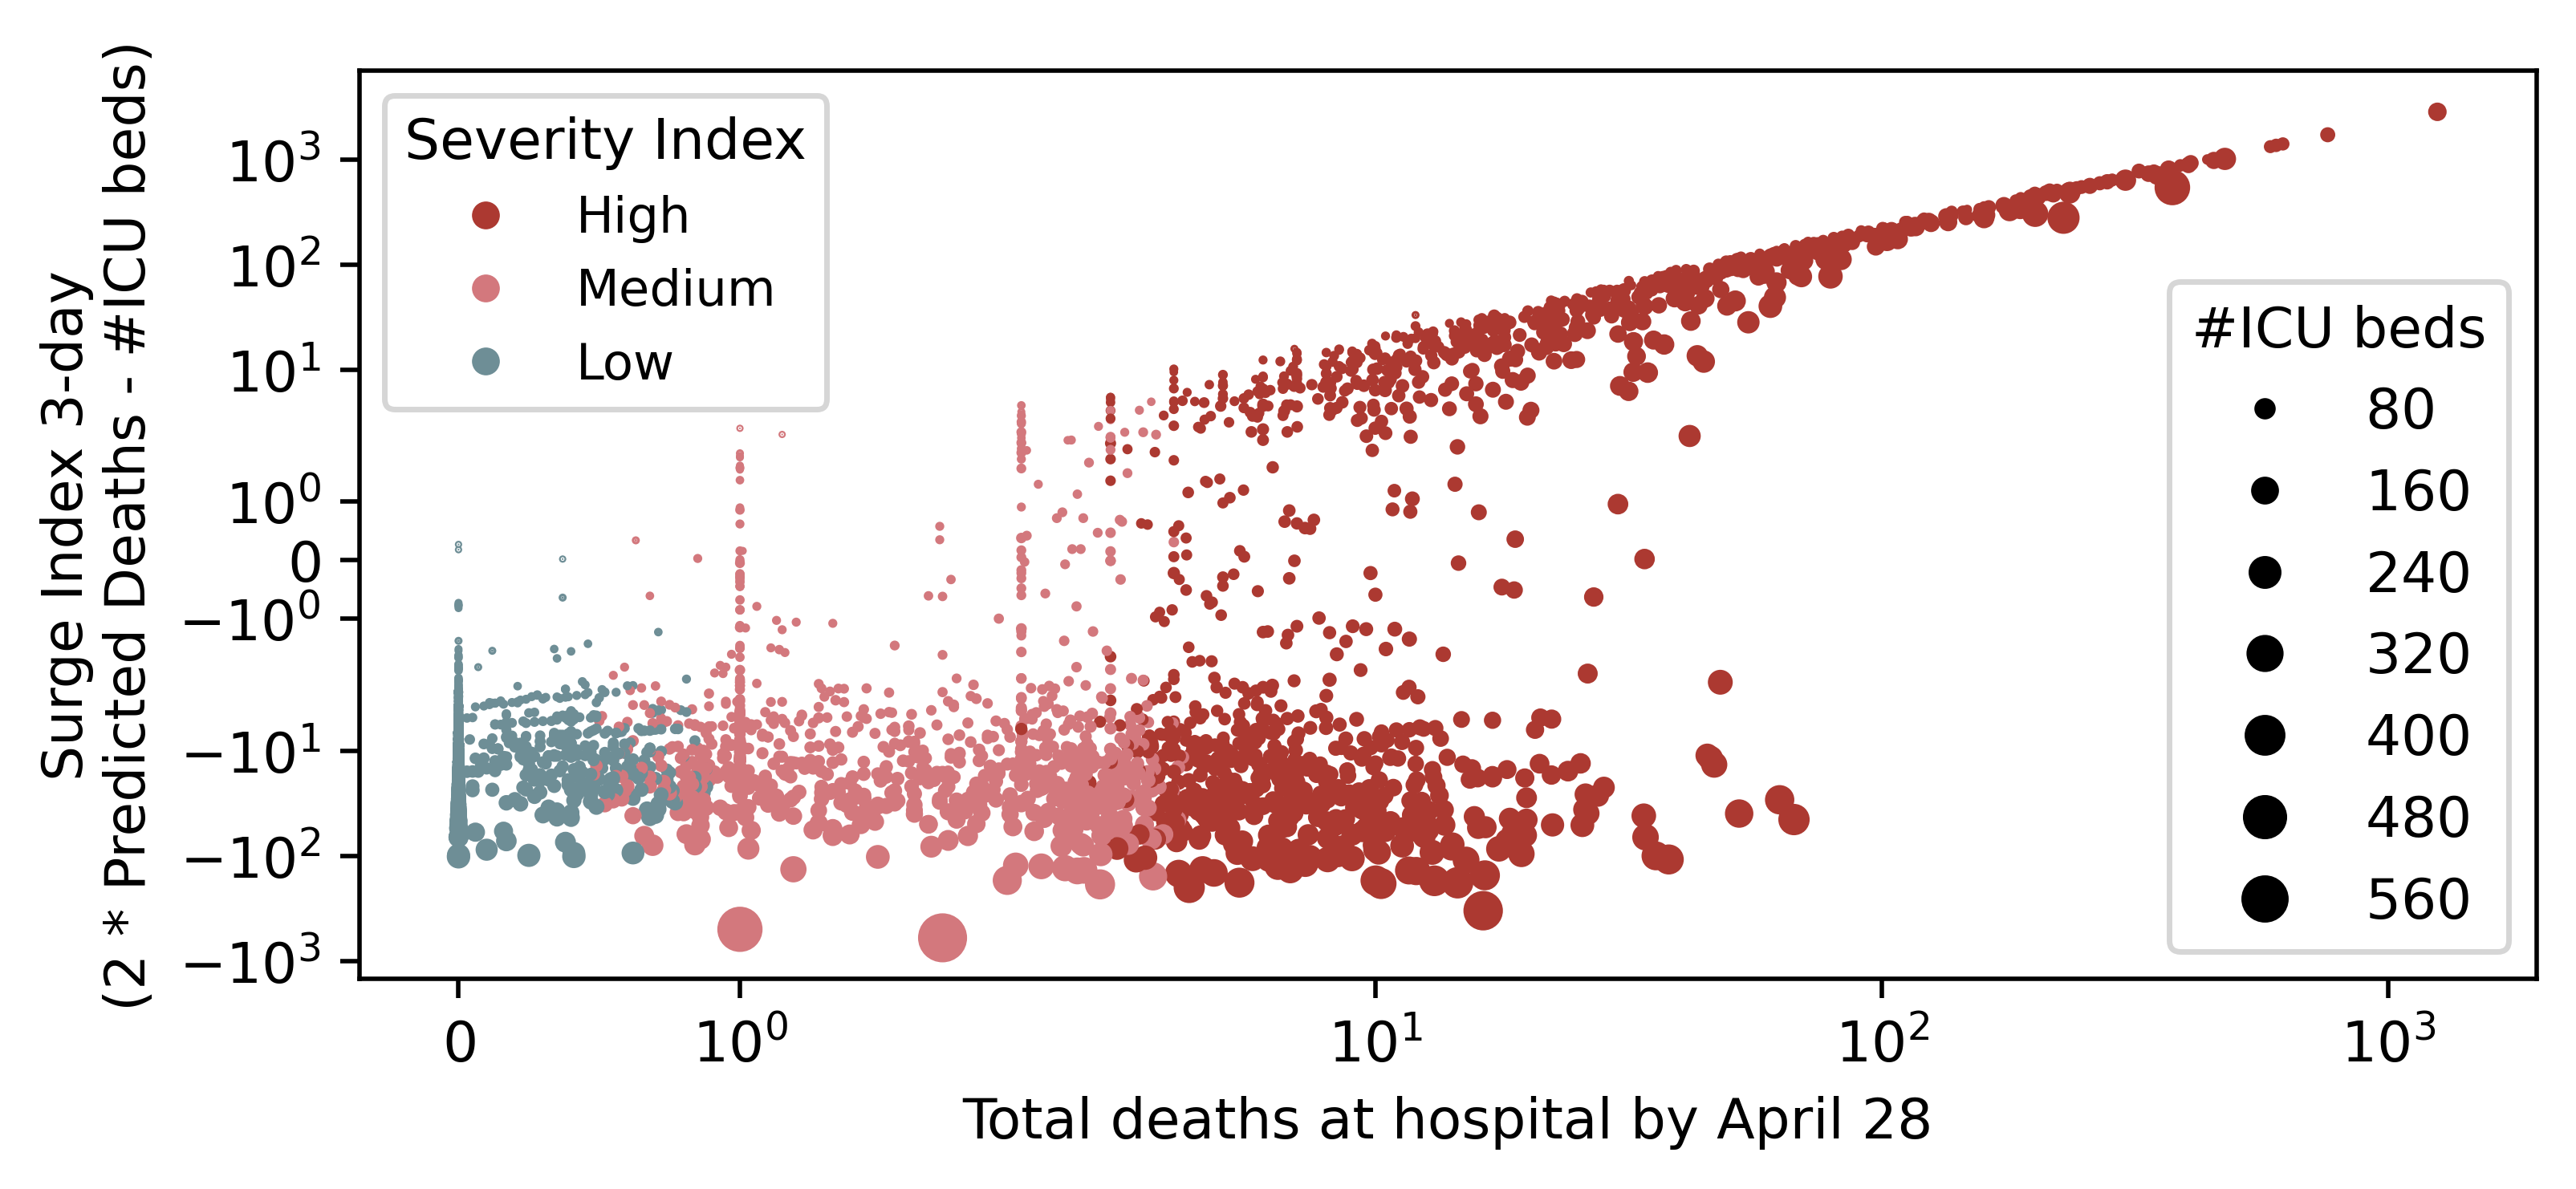

In [36]:
today = datetime.today().strftime("%B %d")
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
cs_d = {i: cs[i-1] for i in [1, 2, 3]}
# cs = ['#91bfdb','#dec34b','#fc8d59']
markersize_rescaling = 10
x = d['Total Deaths Hospital']
y = d['Surge 3-day']
c = [cs_d[x] for x in d['Severity 3-day']] # d['Severity 3-day'] #
s = d['ICU Beds'] / markersize_rescaling
xlab = f'Total deaths at hospital by {today}'
ylab = 'Surge Index 3-day\n(2 * Predicted Deaths - #ICU beds)'
colorlab = 'Severity Index'
sizelab = '#ICU beds'

viz_static.plot_scatter(x, y, c, s, xlab, ylab, colorlab, sizelab, markersize_rescaling)
plt.show()

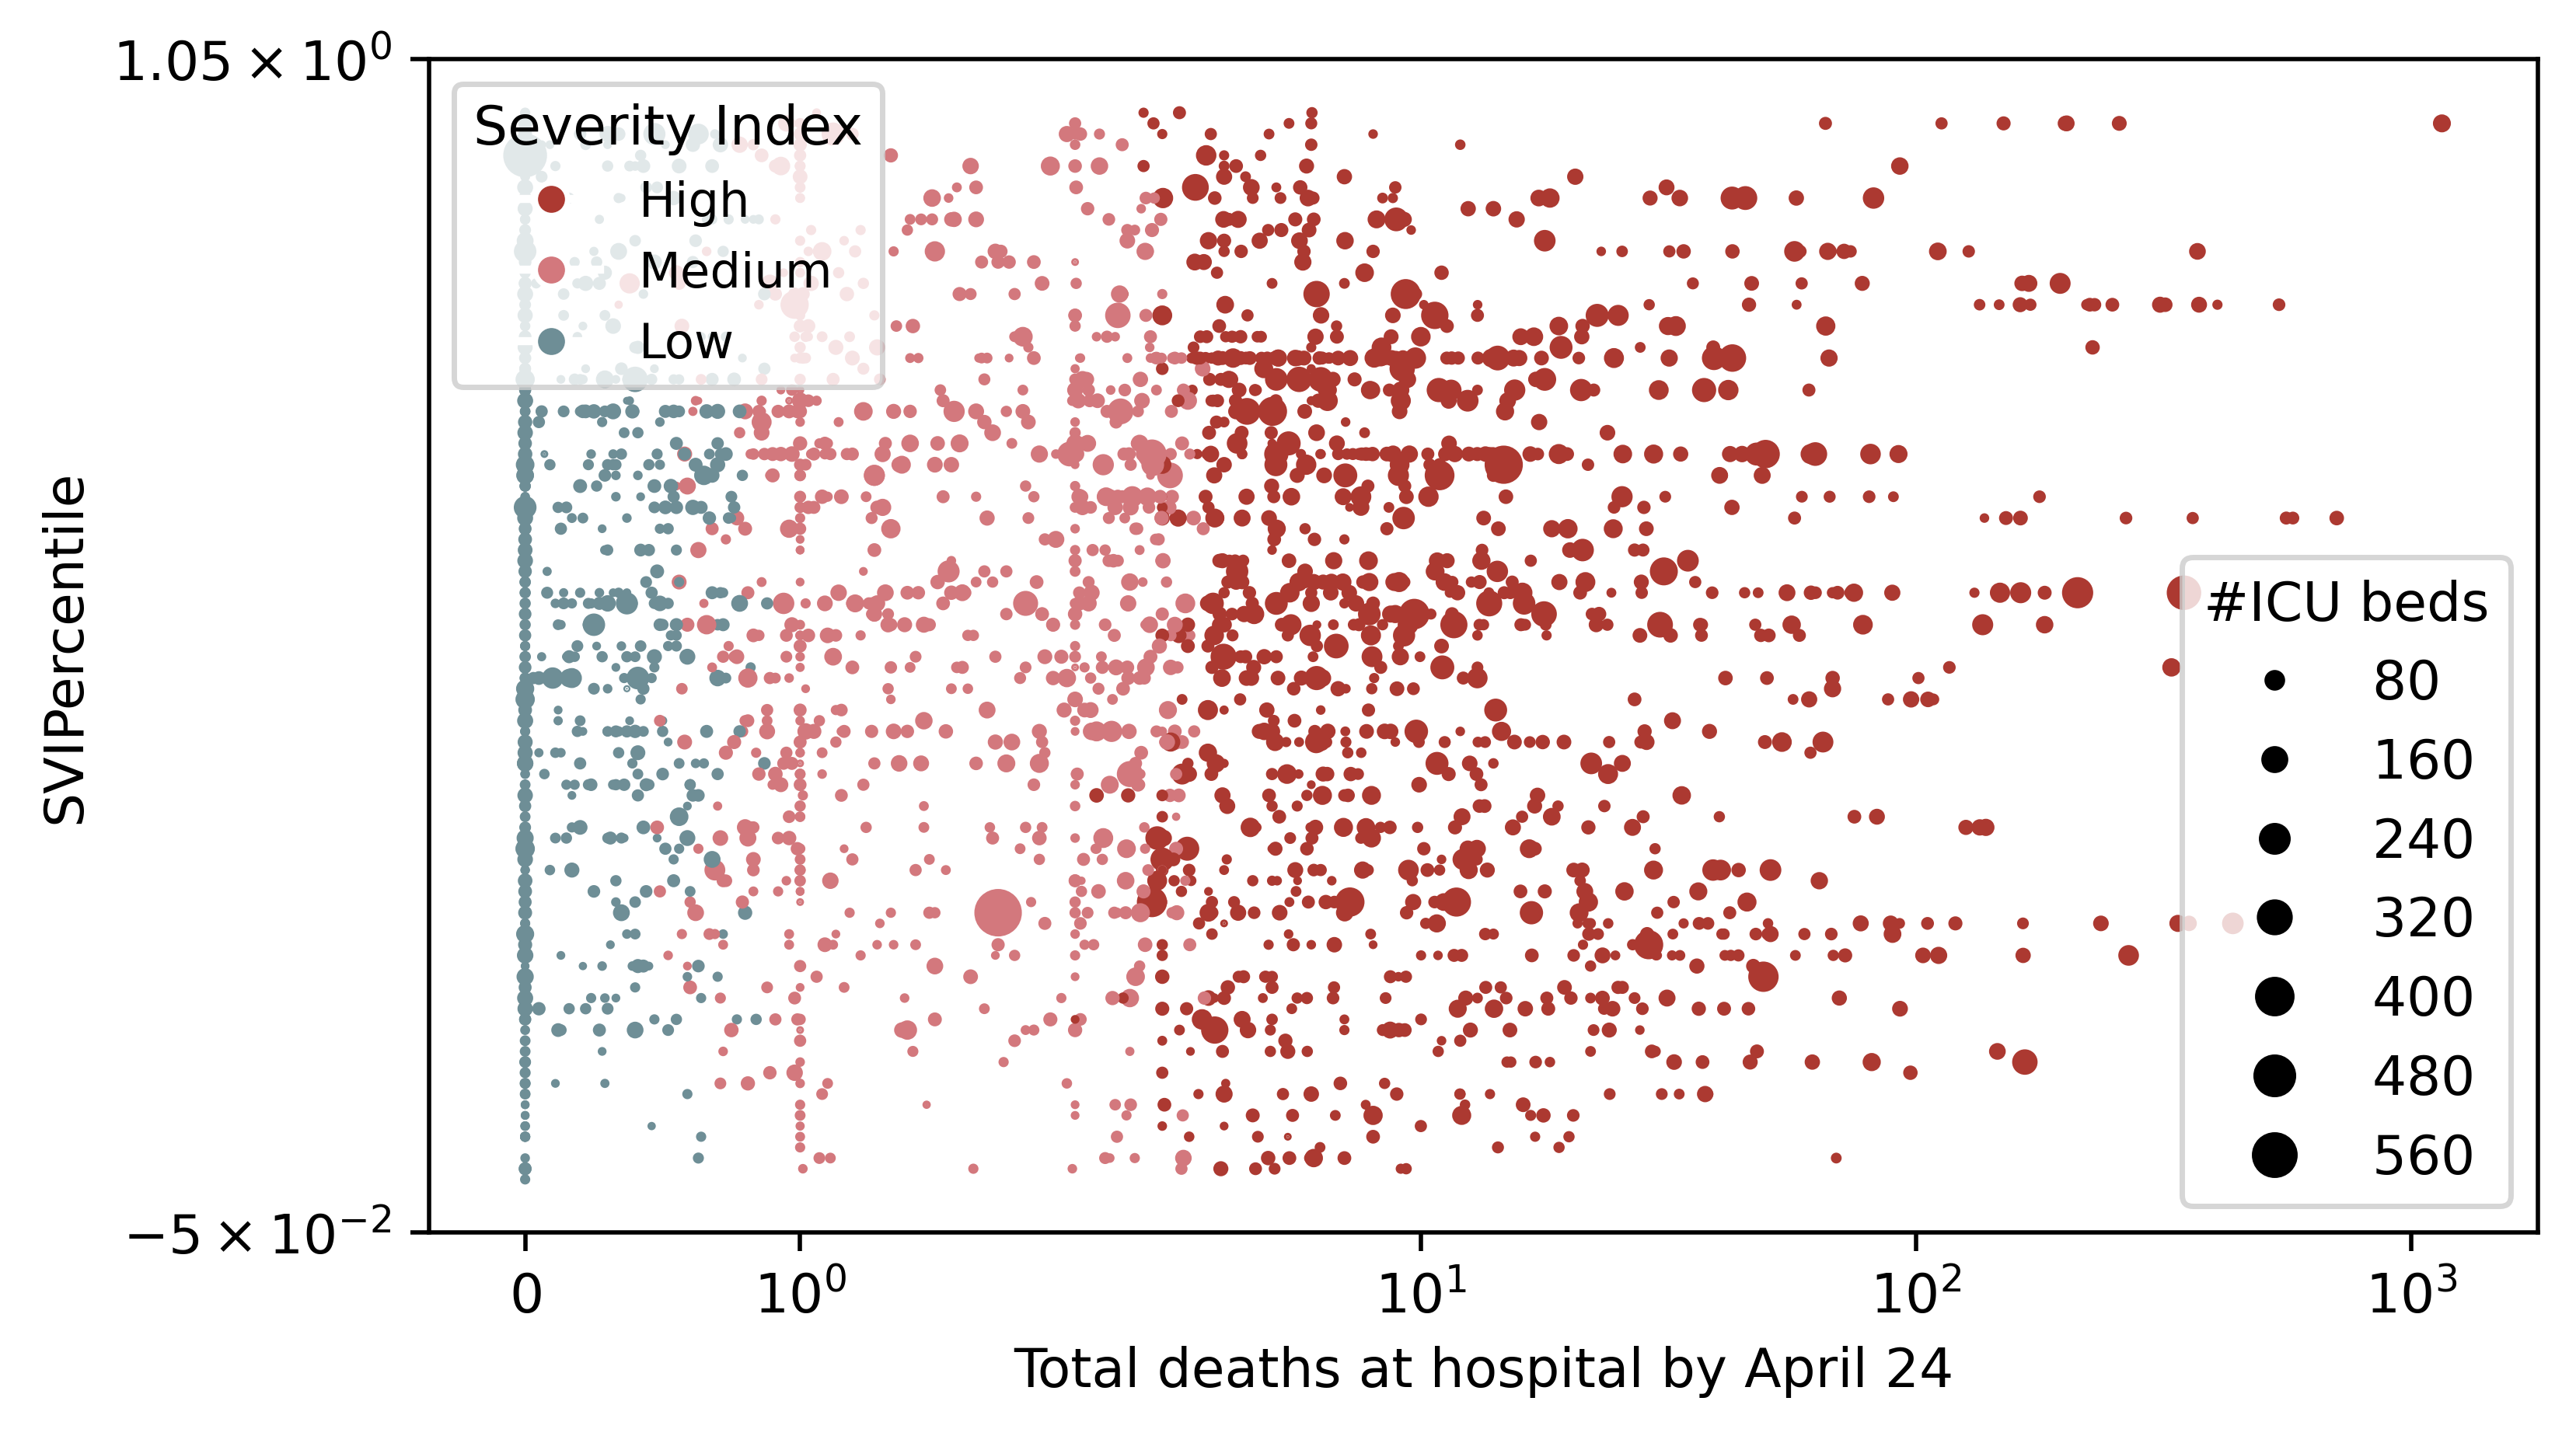

In [4]:
today = datetime.today().strftime("%B %d")
remap = {1: 'Low', 2: 'Medium', 3: 'High'}
cs_d = {i: cs[i-1] for i in [1, 2, 3]}
# cs = ['#91bfdb','#dec34b','#fc8d59']
markersize_rescaling = 10
x = d['Total Deaths Hospital']
y = d['SVIPercentile']
c = [cs_d[x] for x in d['Severity 3-day']] # d['Severity 3-day'] #
s = d['ICU Beds'] / markersize_rescaling
xlab = f'Total deaths at hospital by {today}'
ylab = 'SVIPercentile'
colorlab = 'Severity Index'
sizelab = '#ICU beds'

viz_static.plot_scatter(x, y, c, s, xlab, ylab, colorlab,
                        sizelab, markersize_rescaling, figsize=(7, 4))
plt.show()

# adjustments

**different measures of hospital size are pretty consistent**

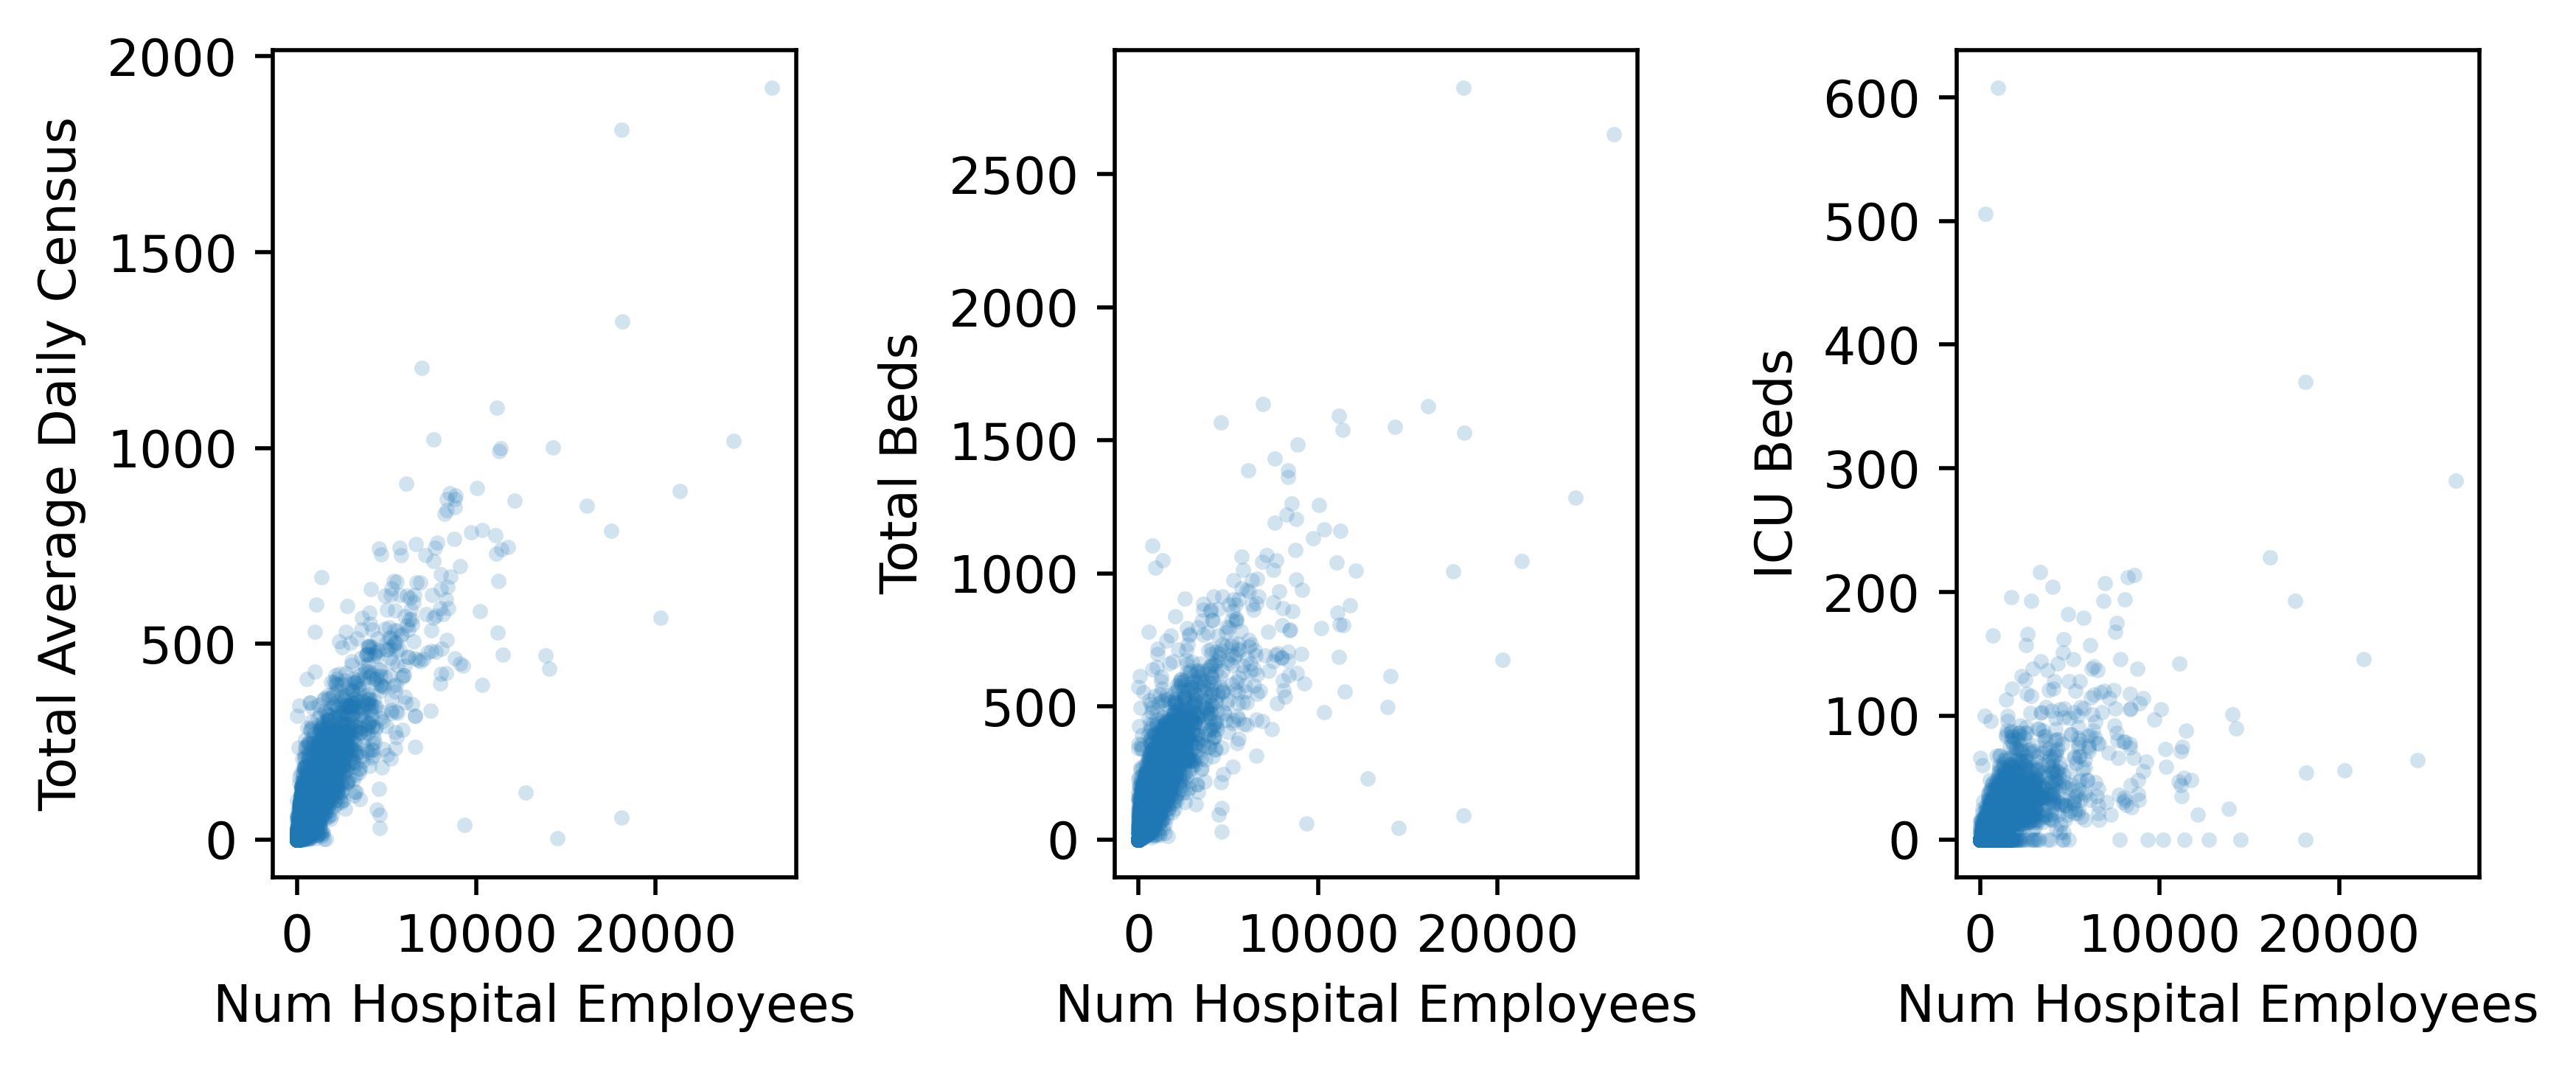

In [11]:
plt.figure(dpi=500, figsize=(7, 3), facecolor='w')
R, C = 1, 3
plt.subplot(R, C, 1)
plt.plot(df['Hospital Employees'], df['Total Average Daily Census'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Average Daily Census')

plt.subplot(R, C, 2)
plt.plot(df['Hospital Employees'], df['Total Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('Total Beds')

plt.subplot(R, C, 3)
plt.plot(df['Hospital Employees'], df['ICU Beds'], '.', alpha=0.2, markeredgewidth=0)
plt.xlabel('Num Hospital Employees')
plt.ylabel('ICU Beds')

plt.tight_layout()
plt.show()

**other measures are harder to parse...**

In [ ]:
ks = ['Predicted Deaths Hospital 2-day', "Hospital Employees", 'ICU Beds']
R, C = 1, len(ks)
plt.figure(dpi=300, figsize=(C * 3, R * 3))

for c in range(C):
    plt.subplot(R, C, c + 1)
    if c == 0:
        plt.ylabel('Total Occupancy Rate')
    plt.plot(df[ks[c]], df['Total Occupancy Rate'], '.', alpha=0.5)
    plt.xlabel(ks[c])

plt.tight_layout()
plt.show()

**different hospital types**

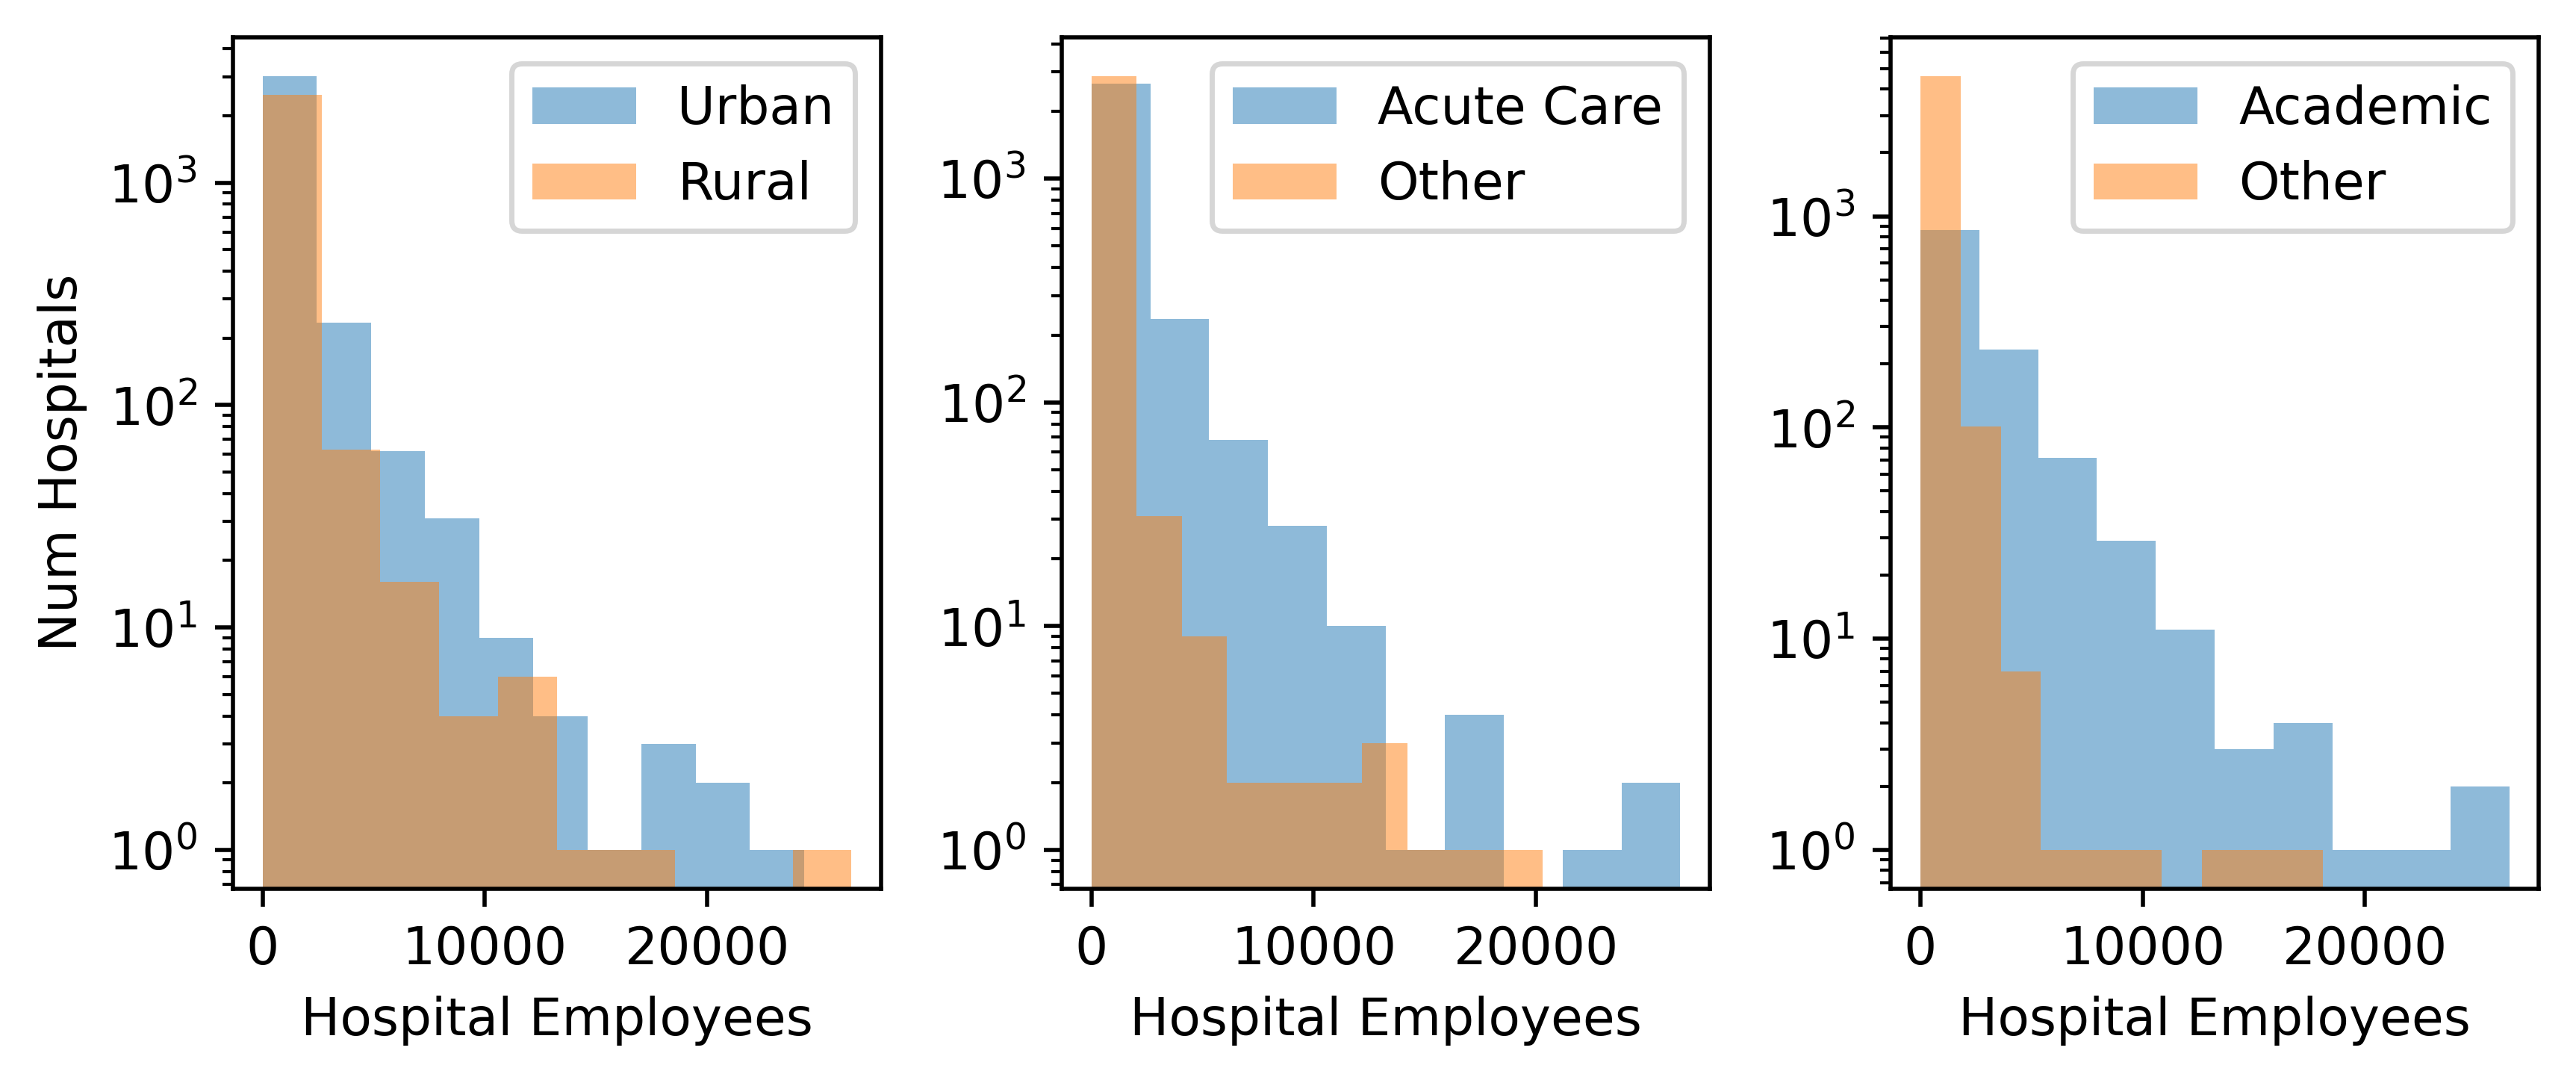

In [13]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
a = 0.5
s = 'Hospital Employees'
plt.subplot(R, C, 1)
idxs = df.IsUrbanHospital == 1
plt.hist(df[idxs][s], label='Urban', alpha=a)
plt.hist(df[~idxs][s], label='Rural', alpha=a)
plt.ylabel('Num Hospitals')
plt.xlabel(s)
plt.yscale('log')
plt.legend()

plt.subplot(R, C, 2)
idxs = df.IsAcuteCareHospital == 1
plt.hist(df[idxs][s], label='Acute Care', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')
plt.legend()

plt.subplot(R, C, 3)
idxs = df.IsAcademicHospital == 1
plt.hist(df[idxs][s], label='Academic', alpha=a)
plt.hist(df[~idxs][s], label='Other', alpha=a)
plt.xlabel(s)
plt.yscale('log')

plt.legend()
plt.tight_layout()
plt.show()

**rural areas have lower occupancy rates**

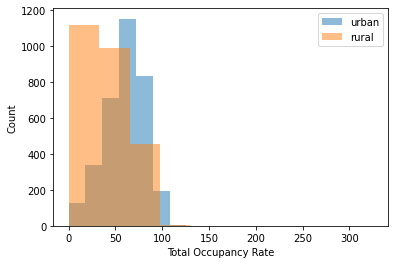

In [14]:
idxs = df.IsUrbanHospital == 1
plt.hist(df['Total Occupancy Rate'][idxs], label='urban', alpha=0.5)
plt.hist(df['Total Occupancy Rate'][~idxs], label='rural', alpha=0.5)
plt.xlabel('Total Occupancy Rate')
plt.ylabel('Count')
plt.legend()
plt.show()

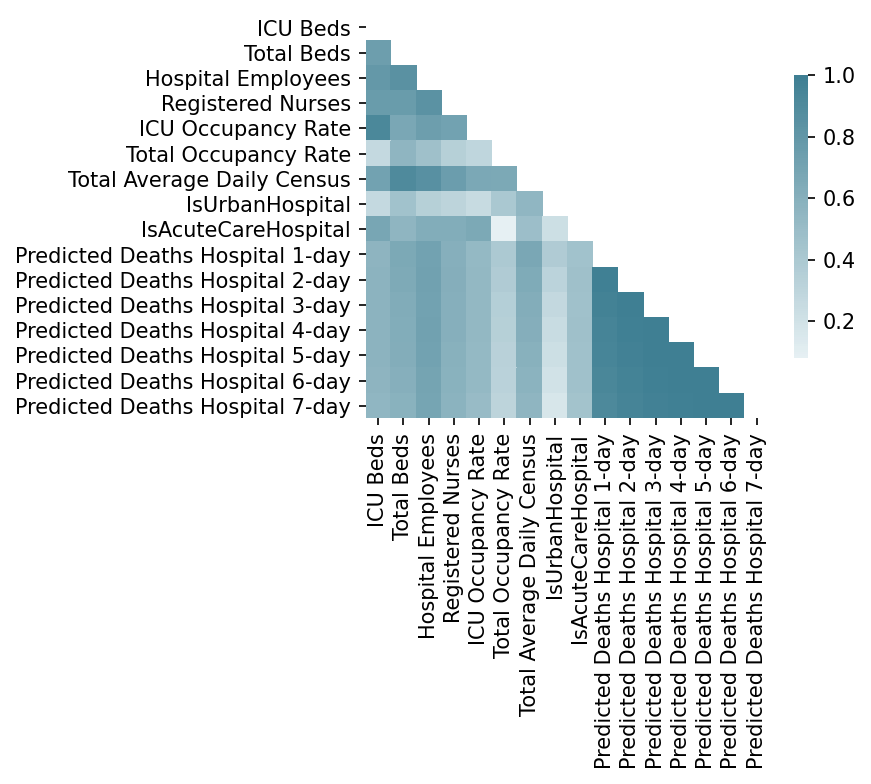

In [16]:
ks = ['ICU Beds', 'Total Beds', 
      'Hospital Employees', 'Registered Nurses',
      'ICU Occupancy Rate', 'Total Occupancy Rate',
      'Mortality national comparison', 'Total Average Daily Census',
      
#       'IsAcademicHospital', 
      'IsUrbanHospital', 'IsAcuteCareHospital']
      
      

# ks += [f'Predicted Deaths {n}-day' for n in NUM_DAYS_LIST]
ks += [f'Predicted Deaths Hospital {n}-day' for n in NUM_DAYS_LIST]

# county-level stuff
# ks += ['unacast_n_grade', Hospital Employees in County', 'tot_deaths', 'tot_cases', 'PopulationDensityperSqMile2010'] 


viz_static.corrplot(df[ks], SIZE=6)

**rural vs urban**

3366 urban hospitals, 2577 rural


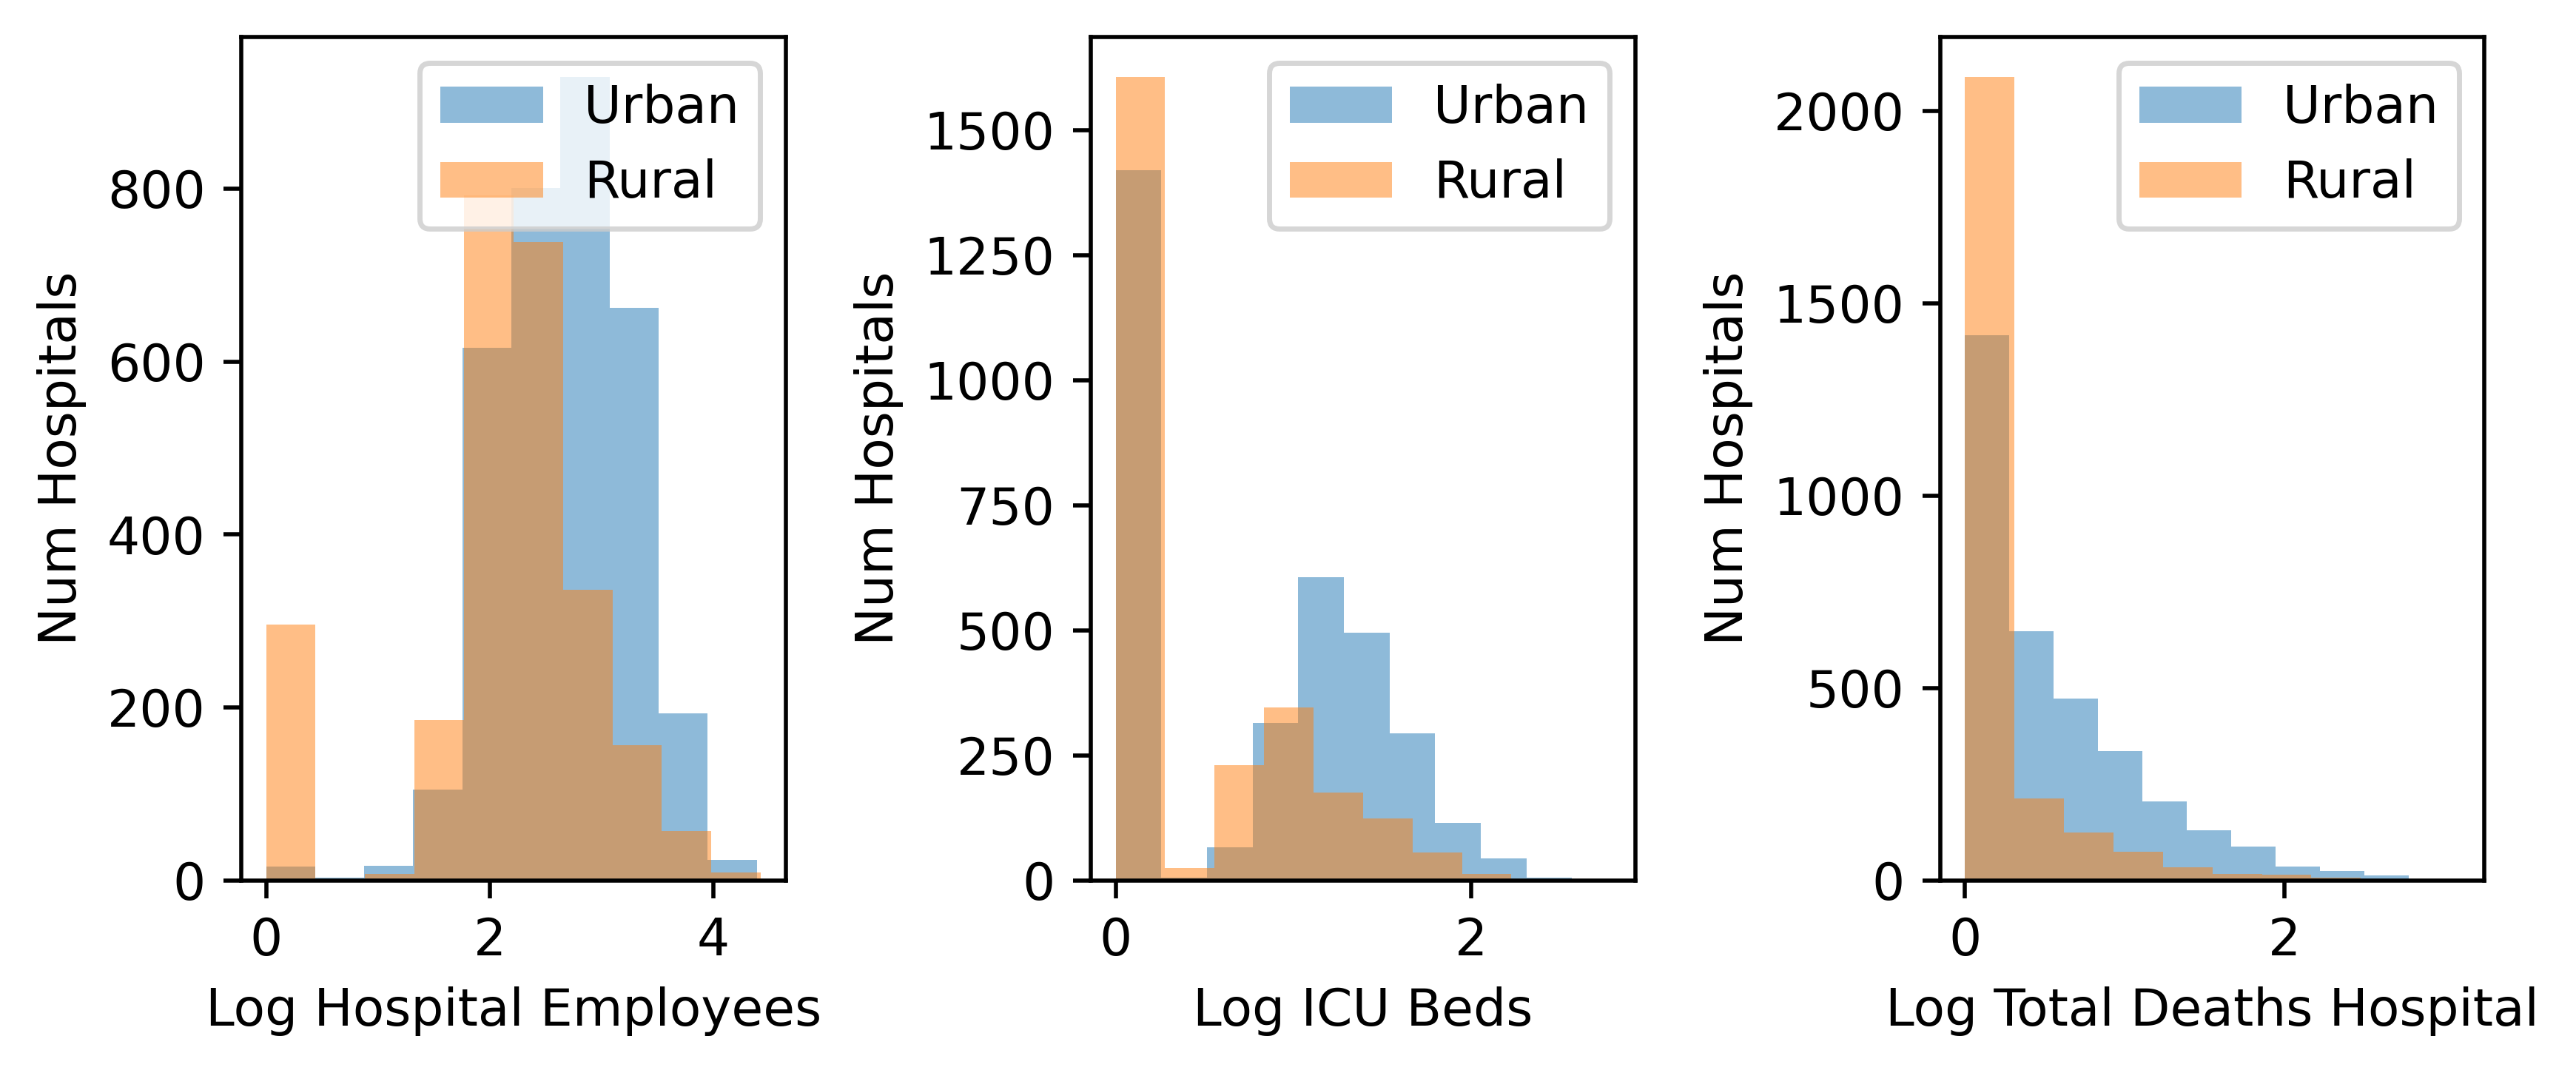

In [34]:
plt.figure(dpi=500, figsize=(7, 3))
R, C = 1, 3
a = 0.5

idxs = df['Urban or Rural Designation'] == 'Urban'
urb = df[idxs]
rur = df[~idxs]

print(f'{urb.shape[0]} urban hospitals, {rur.shape[0]} rural')
for i, s in enumerate(['Hospital Employees', 'ICU Beds', 'Total Deaths Hospital']):
    plt.subplot(R, C, i + 1)
    plt.ylabel('Num Hospitals')
    plt.xlabel('Log ' + s)
#     plt.xscale('log')
#     plt.yscale('log')
    plt.hist(np.log10(urb[s] + 1), label='Urban', alpha=a)
    plt.hist(np.log10(rur[s] + 1), label='Rural', alpha=a)
    plt.legend()


plt.tight_layout()
plt.show()